https://www.tensorflow.org/responsible_ai/privacy/tutorials/privacy_report

https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack

Perform first category EMD during inference phase

I want a generalized apporach where I can use TF reports on pytorch models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow import keras
import tensorflow as tf

# Define the neural network architecture
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.reshape=nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.nonlinear = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.reshape(x)
        # x = torch.flatten(x, start_dim=1)
        # x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x= self.nonlinear(x)
        # x = torch.softmax(x, dim=1)
        return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64*20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64*20, shuffle=False)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


2023-04-19 08:26:54.145725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:26:54.849931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model.to('cpu')

MNISTClassifier(
  (reshape): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (nonlinear): Softmax(dim=1)
)

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.interpolate import CubicSpline
import numpy as np
from PyEMD import EMD
import torch.nn.functional as F

def taylor_approximation_softmax(x, x0,temperature=1.0):
    softmax_x0 = F.softmax(x0, dim=-1)
    diff = x - x0
    jacobian = torch.zeros_like(x0).unsqueeze(-1).repeat(1, 1, x.size(-1))
    
    for i in range(x.size(-1)):
        for j in range(x.size(-1)):
            delta_ij = 1 if i == j else 0
            jacobian[..., i, j] = softmax_x0[..., i] * (delta_ij - softmax_x0[..., j])
    
    linear_term = torch.matmul(jacobian, diff.unsqueeze(-1)).squeeze(-1)
    return softmax_x0 + 1/temperature*linear_term


def softmax_approximation(x,temperature=1.0):
    # Compute the second-order Taylor series approximation of the exponential function
    exp_approx = 1 + 1/temperature*x + 0.5 * x ** 2

    # Compute the sum of the approximated exponential values along the last dimension
    exp_sum = torch.sum(exp_approx, dim=-1, keepdim=True)

    # Divide each approximated exponential value by the sum to get the approximated softmax
    softmax_approx = exp_approx / exp_sum

    return softmax_approx


def approxim(output):
    Out=[]
    for i in range(len(output)):

        #flatten output
        sub_out = output[i]

        sub_out_0=torch.zeros_like(sub_out)

        #compute taylor approximation
        y_first_order=taylor_approximation_softmax(sub_out,sub_out_0,temperature=2.0)
        y_first_order=torch.flatten(y_first_order)
        out_approx_first_order=y_first_order.numpy()


        #compute softmax approximation
        y_second_order=softmax_approximation(sub_out_0,temperature=2.0)
        y_second_order=torch.flatten(y_second_order)
        out_approx_second_order=y_second_order.numpy()

        #append to list
        Out.append(out_approx_first_order)
        # Out.append(out_approx_second_order)

    #convert to numpy
    outputs = np.array(Out)

    #convert to torch tensor
    outputs = torch.from_numpy(outputs)
    return outputs

In [4]:

in_preds = []
in_label = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        # inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = approxim(outputs)
        #load outputs to cpu
        outputs = outputs.cpu()
        test=outputs
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy before Linearization is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

Test Accuracy before Linearization is:  0.8919


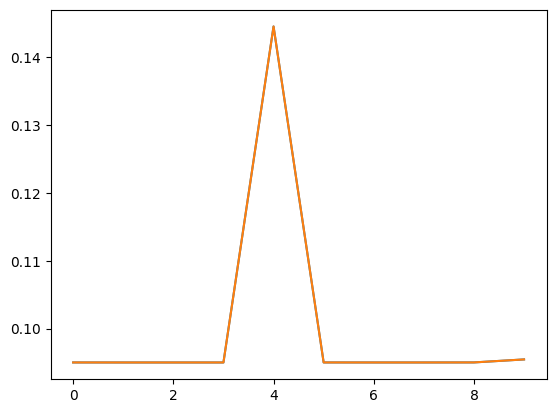

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(test[0])
plt.plot(outputs[0])

In [6]:
# count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 109,386 trainable parameters


In [7]:
target_model = model.to('cpu')

In [8]:
target_model.eval()

MNISTClassifier(
  (reshape): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (nonlinear): Softmax(dim=1)
)

In [9]:
import time
input_tensor=torch.randn((1, 1, 28, 28))

model.eval()
# Perform a warm-up run to avoid potential overhead caused by initial device setup
with torch.no_grad():
    _ = approxim(target_model(input_tensor).detach())



num_iterations = 1000  # Choose a suitable number of iterations to average over

start_time = time.time()
with torch.no_grad():
    for _ in range(num_iterations):
        _ = approxim(target_model(input_tensor).detach())
end_time = time.time()

inference_latency = (end_time - start_time) / num_iterations
#convert to microseconds
inference_latency = inference_latency * 1000000
print(f'Inference latency: {inference_latency:.20f} micro-seconds')



Inference latency: 2608.89506340026855468750 micro-seconds
